In [59]:
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy.signal import savgol_filter
import math
import boris_extraction as boris
import pandas as pd
from scipy.stats import sem
from statistics import mean
from scipy.stats import wilcoxon

In [48]:

def get_spike_specs(path):
    
    """
    imports a spike_time and spike_unit from phy folder
    deletes spikes from units labeled noise in unit and timestamp array
    
    Args (1):
        path: path to phy folder
        path format: './folder/folder/phy'
    
    Returns (2):
        timestamps: numpy array of spike timestamps relative to sampling rate
        unit_array: numpy array of unit ids relative to timestamp array 
    """
    
    timestamps = 'spike_times.npy'
    unit = 'spike_clusters.npy'
    labels_dict = get_unit_labels(path)
    
    timestamps = np.load(os.path.join(path, timestamps))
    unit_array = np.load(os.path.join(path, unit))
   
    spikes_to_delete = []
   
    for spike in range(len(timestamps)): 
        if labels_dict[unit_array[spike].astype(str)] == 'noise':
                spikes_to_delete.append(spike)
        if spike != 0:
            if timestamps[spike - 1] == timestamps[spike]:
                print('2 spikes in a sampling')
                
    timestamps = np.delete(timestamps, spikes_to_delete)
    unit_array = np.delete(unit_array, spikes_to_delete)
    
    return timestamps, unit_array

def get_unit_labels(path):
    """
    creates a dictionary with unit id as key and label as value
    labels: good, mua, noise 
    
    Arg (1):
        path: path to phy folder
        
    Return (1):
        labels_dict: dict, unit ids (str): label (str)
    """
    
    labels = 'cluster_group.tsv'
    with open(os.path.join(path, labels), 'r') as f:
        reader = csv.DictReader(f, delimiter='\t')
        labels_dict = {row['cluster_id']: row['group'] for row in reader}
        
    return labels_dict

def get_unit_timestamps(timestamp_array, unit_array):
    """
    creates a dictionary of units to spikes
    values are spike timestamp arrays associated with the unit as key
    no noise units are included
    
    Arg(2):
        timestamp_array: numpy array, spike timestamps
        unit_array: numpy array, unit ids associated with spikes
    
    Return (1):
        timestamp_dict: dict, unit id (int) as keys, spike timestamps (numpy array) as values 
    """
    
    timestamp_dict = {}
    for spike in range(len(timestamp_array)): 
        if unit_array[spike] in timestamp_dict.keys():
            timestamp_list = timestamp_dict[unit_array[spike]] 
            timestamp_list = np.append(timestamp_list, timestamp_array[spike])
            timestamp_dict[unit_array[spike]] = timestamp_list
        else:
            timestamp_dict[unit_array[spike]] = timestamp_array[spike]
    
    return timestamp_dict

    
def get_spiketrain(timestamp_array, recording_length, sampling_rate = 20000):
    """
    creates a spiketrain of ms time bins 
    each array element is the number of spikes recorded per ms
    if recording (timestamp_array) is longer than the recording_length given,
    the amount of dropped data will be printed in a message
    
    
    Args (3, 2 required):
        timestamp_array: numpy array, spike timestamp array
        recording_length: int, length of recording (min)
        sampling_rate: int, default=20000, sampling rate of ephys recording
        
    Returns:
        spiketrain_ms_timebins: a numpy array 
            array elements are number of spikes per ms 
    """
    
    recording_length = recording_length * 60 * sampling_rate
    hz_to_ms = int(sampling_rate*.001)
    spiketrain = np.zeros(recording_length + 1)
    for i in range(len(timestamp_array)):
        try:
            spiketrain[timestamp_array[i]] = 1
        except IndexError:
            dropped_recording = (timestamp_array[-1] - recording_length)/20000
            if dropped_recording > 0: 
                print(f"you are dropping {dropped_recording} seconds of recorded data")
            else:
                print("recording length is shorter than specified")
            break
        
    spiketrain_ms_timebins = np.zeros(math.floor(len(spiketrain)/hz_to_ms)) 
    ms_bin = 0
    
    for i in range(0, len(spiketrain), hz_to_ms):
        try:
            spiketrain_ms_timebins[ms_bin] = sum(spiketrain[i:i+hz_to_ms])
            ms_bin += 1
        except IndexError:
            #should i pad?
            pass

    return spiketrain_ms_timebins
        
def get_firing_rate(spiketrain, smoothing_window = 250, timebin = 1):
    """
    calculates firing rate (spikes/second)
    
    Args (3, 1 required):
        spiketrain: numpy array, in 1 ms time bin
        recording_length: int, length of recording (min)
        smoothing_window: int, default = 250, smoothing average window (ms)
            min smoothing_window = 1
        timebin: int, default = 1, window (ms) of firing rates returned

    Return (1):
        firing_rate: numpy array of firing rates in timebin sized windows
        
    """ 
    
    if timebin != 1:
        current_timebin = 0
        temp_spiketrain = np.zeros(math.ceil(len(spiketrain)/timebin))
        for i in range(0, len(spiketrain), timebin):
            try:
                temp_spiketrain[current_timebin] = sum(spiketrain[i:i+timebin])
                current_timebin += 1
            except IndexError:
                #should i pad here or just drop it? 
                temp_spiketrain[current_timebin] = sum(spiketrain[i:])
        spiketrain = temp_spiketrain
    firing_rate = np.empty(len(spiketrain) - smoothing_window)
    rolling_sum = sum(spiketrain[0:smoothing_window])
    for i in range(len(firing_rate)):
        firing_rate[i] = rolling_sum / (smoothing_window * .001 * timebin)
        rolling_sum = rolling_sum - spiketrain[i] + spiketrain[i+smoothing_window]
        
    return firing_rate

def get_unit_spiketrains(labels_dict, spike_dict, recording_length, sampling_rate = 20000):  
    """
    Creates a dictionary of spiketrains per good unit 
    where unit id is key and unit spike train is value
    does not create spiketrains for mua's
    
    Args (4, 3 required):
        labels_dict: dict, unit id for keys and labels for values
        spike_dict: dict, unit id for keys and spike timestamps for values
        recording_length: int, recording length in min
        sampling_rate: int, default=20000, sampling rate of ephys recording
        
    Reutrn (1):
        unit_spiketrains: dict, unit ids as keys and unit spiketrains (in 1 ms timebins)
        
    """
    unit_spiketrains = {}
    
    for unit in spike_dict.keys():
        if labels_dict[str(unit)] == 'good':
            unit_spiketrains[unit] = get_spiketrain(spike_dict[unit], recording_length, sampling_rate)
            
    return unit_spiketrains

def get_unit_firing_rates(labels_dict, spike_dict, recording_length, smoothing_window = 250, timebin = 1, sampling_rate = 20000):  
    """
    Calculates firing rates per unit 
    
    Args (6, 3 required):
        labels_dict:dict, unit id for keys and labels for values
        spike_dict: dict, unit id for keys and spike timestamps for values
        recording_length: int, recording length in min
        smoothing_window: int, default = 250, smoothing average window (ms)
            min smoothing_window = 1
        timebin: int, default = 1, window (ms) of firing rates returned
        sampling_rate: int, default=20000, sampling rate of ephys recording
        
    Return (1):
        unit_firing_rates: dict, unit ids as keys and unit firing rates as values
    """
    unit_firing_rates = {}
    for unit in spike_dict.keys():
        if labels_dict[str(unit)] == 'good':
            spiketrain = get_spiketrain(spike_dict[unit], recording_length, sampling_rate)
            unit_firing_rates[unit] = get_firing_rate(spiketrain, smoothing_window, timebin)
        
    return unit_firing_rates

def get_event_spiketrains(events, timestamp_array, pre_window, post_window, recording_length, sampling_rate):
    event_spiketrains = []
    spiketrain = get_spiketrain(timestamp_array, recording_length, sampling_rate)
    pre_window_ms = pre_window*1000
    post_window_ms = post_window*1000
    longest_event = 0
    event_lengths = []
    for i in range(events.shape[0]):
        event_length = int(events[i][1] - events[i][0])
        event_lengths.append(event_length)
        if event_length > longest_event:
            longest_event = event_length
    for i in range(events.shape[0]):
        event_diff = int(longest_event - event_lengths[i])
        pre_event = int(events[i][0] - pre_window_ms)
        post_event = int(events[i][1] + post_window_ms + event_diff)
        event_spiketrain = spiketrain[pre_event:post_event]
        event_spiketrains.append(event_spiketrain)
    return event_spiketrains

def get_event_firing_rates(events, timestamp_array, recording_length, smoothing_window = 250, timebin = 1,
                           sampling_rate = 20000, pre_window = 0, post_window = 0, equalize = False):
    #to do: write doc string, edit this to have optional same length bouts, 
    #eventually you will want up to two sec of sniff, and two seconds prior to sniff
    """
    calculates firing rates for events
    
    Args (9, 3 required):
        events:numpy array of [[start (ms), stop (ms)] x n events]
        timestamp_array: numpy array of spike timestamps in 1 ms windows 
        recording_length: int, length of recording (min)
        smoothing_window: int, default = 250, smoothing average window (ms)
            min smoothing_window = 1 
        timebin: int, default 1, timebin in ms for firing rate array
        sampling_rate: int, default=20000, sampling rate of ephys recording
        pre_window: int, default = 0, seconds prior to start of event returned
        post_window: int, default = 0, seconds after end of event returned
        equalize: Boolean, default False, if True, equalizes lengths of each event to longest event
        
    Return (1):
        event_firing_rates: lst of numpy arrays of firing rates 
    """
    event_firing_rates = []
    spiketrain = get_spiketrain(timestamp_array, recording_length, sampling_rate)
    pre_window_ms = pre_window*1000
    post_window_ms = post_window*1000
    if equalize:
        longest_event = 0
        event_lengths = []
        for i in range(events.shape[0]):
            event_length = int(events[i][1] - events[i][0])
            event_lengths.append(event_length)
            if event_length > longest_event:
                longest_event = event_length
    for i in range(events.shape[0]):
        if equalize:
            event_diff = int(longest_event - event_lengths[i])
        else:
            event_diff = 0
        pre_event = int(events[i][0] - pre_window_ms)
        post_event = int(events[i][1] + post_window_ms + event_diff)
        event_spiketrain = spiketrain[pre_event:post_event]
        event_firing_rate = get_firing_rate(event_spiketrain)
        event_firing_rates.append(event_firing_rate)
    return event_firing_rates


In [181]:
fam_path = '.\\proc\\20221219_114535_6_1_fam_merged.rec\\phy'
boris_df = pd.read_excel('C:\\Users\megha\\Documents\\Padilla-Coreano\\homecage_social_ephys_vids\\mp4vids\\annotated_behavior_cagfamnov.xlsx')
fam_df = boris_df[boris_df['Observation id'] == 'familiar_6_1_06282023']
cagemate_df = boris_df[boris_df['Observation id'] == 'cagemate_6_1_06282023']
novel_df = boris_df[boris_df['Observation id'] == 'novel_6_1_06282023']

In [182]:

fam_timestamps, fam_units = get_spike_specs(fam_path)
fam_spiketrain = get_spiketrain(fam_timestamps, 20)
unit_labels = get_unit_labels(fam_path)
unit_dict = get_unit_timestamps(fam_timestamps, fam_units)
sniffing_bouts = boris.get_behavior_bouts(fam_df, 'subject', ['anogential sniffing', 'face sniffing'], 2, .3)
fam_event_firingrates = get_event_firing_rates(sniffing_bouts, fam_timestamps, 20, 300)

you are dropping 0.5546 seconds of recorded data
you are dropping 0.5546 seconds of recorded data


In [183]:
print(unit_labels.keys(), unit_dict.keys())
unit = 8

print(unit_labels[str(unit)])

dict_keys(['1', '3', '4', '5', '8', '15', '16', '19', '20', '31', '33', '42', '44', '55', '62', '63', '64', '65', '66', '67', '68']) dict_keys([8, 19, 4, 5, 1, 15, 3, 55, 44, 33, 20, 66, 42, 68])
mua


In [184]:
sniffing_bouts.shape


(15, 2)

In [216]:

trimmed_sniffing_bouts = np.zeros(sniffing_bouts.shape)
pre_sniff_bouts = np.zeros(sniffing_bouts.shape)
for bout in range(len(sniffing_bouts)):
    if sniffing_bouts[bout][1] - sniffing_bouts[bout][0] > 5000:
        trimmed_sniffing_bouts[bout][1] = sniffing_bouts[bout][0]+5000
        trimmed_sniffing_bouts[bout][0] = sniffing_bouts[bout][0]
    else:
        trimmed_sniffing_bouts[bout] = sniffing_bouts[bout]
        
    pre_sniff_bouts[bout] = [(sniffing_bouts[bout][0] - 2001), (sniffing_bouts[bout][0]-1)]






In [217]:
unit_averages = {}
unit_sniffing_rates = {}
unit_presniff_rates = {}
for unit in unit_dict:
    sniffing_firing_rates = get_event_firing_rates(trimmed_sniffing_bouts, unit_dict[unit], 20, 100, 1, 20000)
    pre_sniffing_firing_rates = get_event_firing_rates(pre_sniff_bouts, unit_dict[unit], 20, 100)
    event_averages = []
    pre_event_averages = []
    for event in range(len(sniffing_firing_rates)):
        event_averages.append(mean(sniffing_firing_rates[event]))
        pre_event_averages.append(mean(pre_sniffing_firing_rates[event]))
    unit_sniffing_rates[unit] = sniffing_firing_rates
    unit_presniff_rates[unit] = pre_sniffing_firing_rates
    unit_averages[unit] = [event_averages, pre_event_averages]
        
    


you are dropping 0.52665 seconds of recorded data
you are dropping 0.52665 seconds of recorded data
you are dropping 0.5546 seconds of recorded data
you are dropping 0.5546 seconds of recorded data
you are dropping 0.5145 seconds of recorded data
you are dropping 0.5145 seconds of recorded data
you are dropping 0.55375 seconds of recorded data
you are dropping 0.55375 seconds of recorded data
you are dropping 0.41345 seconds of recorded data
you are dropping 0.41345 seconds of recorded data
you are dropping 0.51745 seconds of recorded data
you are dropping 0.51745 seconds of recorded data
you are dropping 0.4452 seconds of recorded data
you are dropping 0.4452 seconds of recorded data
you are dropping 0.54315 seconds of recorded data
you are dropping 0.54315 seconds of recorded data
you are dropping 0.4432 seconds of recorded data
you are dropping 0.4432 seconds of recorded data
you are dropping 0.53965 seconds of recorded data
you are dropping 0.53965 seconds of recorded data
you are 

In [218]:
unit_sniffing_rates_prewindow = {}
for unit in unit_dict:
    sniffing_firing_rates = get_event_firing_rates(trimmed_sniffing_bouts, unit_dict[unit], 20, 100, 1, 20000, 2, 0, True)
    unit_sniffing_rates_prewindow[unit] = sniffing_firing_rates

you are dropping 0.52665 seconds of recorded data
you are dropping 0.5546 seconds of recorded data
you are dropping 0.5145 seconds of recorded data
you are dropping 0.55375 seconds of recorded data
you are dropping 0.41345 seconds of recorded data
you are dropping 0.51745 seconds of recorded data
you are dropping 0.4452 seconds of recorded data
you are dropping 0.54315 seconds of recorded data
you are dropping 0.4432 seconds of recorded data
you are dropping 0.53965 seconds of recorded data
you are dropping 0.39335 seconds of recorded data
you are dropping 0.30695 seconds of recorded data
you are dropping 0.38725 seconds of recorded data


In [219]:
wilcoxon_stats = {}
for unit in unit_averages.keys(): 
    wilcoxon_stats[unit] = wilcoxon(unit_averages[unit][0], unit_averages[unit][1])

C:\Users\megha\anaconda3\envs\play\Lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [220]:
wilcoxon_df = pd.DataFrame.from_dict(wilcoxon_stats)
wilcoxon_df



,8,19,4,5,1,15,3,55,44,33,20,66,42,68
0,34.000000,58.000000,35.000000,59.000000,53.000000,49.000000,30.000000,38.000000,60.0,38.000000,30.000000,33.000000,52.000000,40.000000
1,0.151428,0.934082,0.168823,0.977966,0.719727,0.561401,0.094604,0.937473,1.0,0.229309,0.094604,0.135376,0.678772,0.276855


In [195]:
print(unit_averages[33])

[[45.456641341367565, 34.78631519910264, 29.94884054506335, 17.514192849404118, 6.194826637314255, 12.306526315789474, 15.315344341522351, 18.892586989409985, 24.120721383879278, 8.727578947368421, 6.261728395061728, 11.159235668789808, 8.795983086680762, 7.5097534044902465, 14.780172413793103], [15.213473684210527, 46.42021052631579, 30.197894736842105, 29.18063157894737, 10.208, 8.453894736842106, 10.03621052631579, 19.06694736842105, 16.197894736842105, 11.242947368421053, 5.482947368421053, 5.632, 6.383157894736842, 9.97557894736842, 8.467368421052631]]


In [209]:
print(unit_averages[3])
twenty_array = np.array(unit_sniffing_rates_prewindow[20])

[[1.9460309143306262, 1.9831744251261918, 3.8565622758785563, 2.7466955579631636, 9.611447440836544, 1.3852631578947368, 1.6931131695529602, 3.3767019667170954, 9.373573794626425, 2.526315789473684, 6.152098765432099, 6.751592356687898, 2.321353065539112, 6.439455281560544, 0.7183908045977011], [7.570526315789474, 2.4025263157894736, 3.705263157894737, 4.664421052631579, 13.303578947368422, 7.604210526315789, 12.981894736842106, 5.9696842105263155, 4.81178947368421, 4.360421052631579, 8.0, 10.527157894736842, 9.263157894736842, 2.4985263157894737, 6.526315789473684]]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (15,) + inhomogeneous part.

In [213]:
len(unit_sniffing_rates_prewindow[20][1])

6783

(6750,)


ValueError: x and y must have same first dimension, but have shapes (1,) and (6750,)

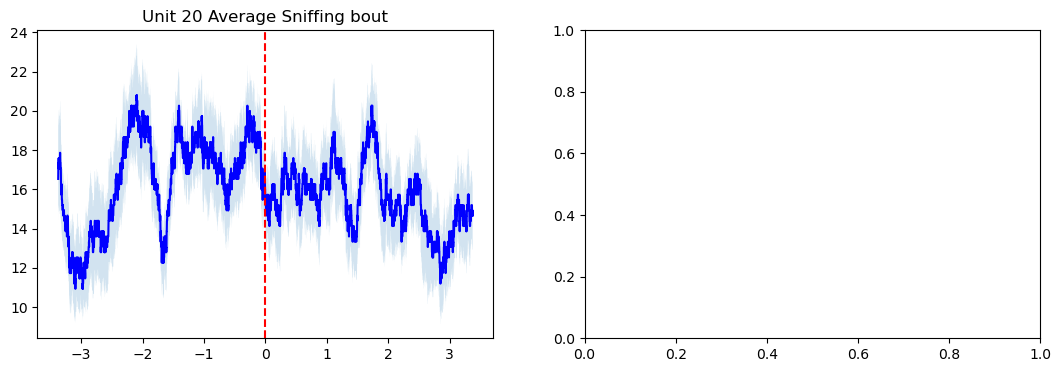

In [223]:
mean_arr = np.mean(unit_sniffing_rates_prewindow[20], axis=0)
sem_arr = sem(unit_sniffing_rates_prewindow[20], axis=0)
pos_sem = mean_arr+sem_arr
neg_sem = mean_arr-sem_arr
x = np.array  (range  (    -int(mean_arr.shape[0]/2),int(mean_arr.shape[0]/2)   )    )
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.plot(x*.001, mean_arr, c= 'b')
plt.axvline(x=0, color='r', linestyle='--')
plt.fill_between(x*.001, neg_sem, pos_sem, alpha=0.2)
plt.title('Unit 20 Average Sniffing bout')

three_mean_arr = np.mean(unit_sniffing_rates_prewindow[3], axis = 0)
three_sem_arr = sem(unit_sniffing_rates_prewindow[3], axis=0)
three_pos_sem = three_mean_arr+three_sem_arr
three_neg_sem = three_mean_arr-three_sem_arr
three_x = np.array (range (-2,5,1000 ))
print(three_mean_arr.shape)
plt.subplot(1,3,2)
plt.plot(three_x*.001, three_mean_arr, c= 'b')
plt.axvline(x=0, color='r', linestyle='--')
plt.fill_between(three_x*.001, three_neg_sem, three_pos_sem, alpha=0.2)
plt.title('Unit 3 Average Sniffing bout')


sixtyeight_mean_arr = np.mean(unit_sniffing_rates_prewindow[68], axis = 0)
sixtyeight_sem_arr = sem(unit_sniffing_rates_prewindow[68], axis=0)
sixtyeight_pos_sem = sixtyeight_mean_arr+sixtyeight_sem_arr
sixtyeight_neg_sem = sixtyeight_mean_arr-sixtyeight_sem_arr
sixtyeight_x = np.array  (range  (    -int(sixtyeight_mean_arr.shape[0]/2),int(sixtyeight_mean_arr.shape[0]/2)   )    )
plt.subplot(1,3,3)
plt.plot(sixtyeight_x*.001, sixtyeight_mean_arr, c= 'b')
plt.axvline(x=0, color='r', linestyle='--')
plt.fill_between(sixtyeight_x*.001, sixtyeight_neg_sem, sixtyeight_pos_sem, alpha=0.2)
plt.title('Unit 68 Average Sniffing bout')



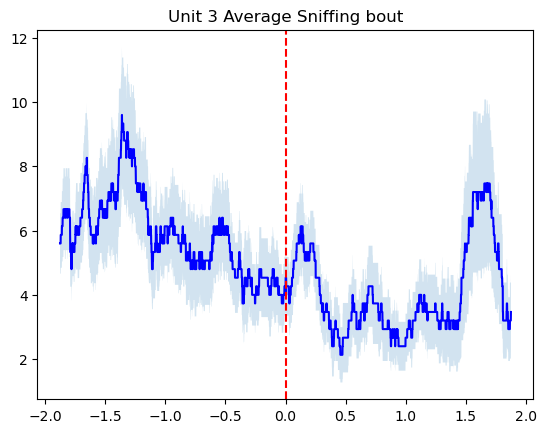

In [167]:

plt.show()

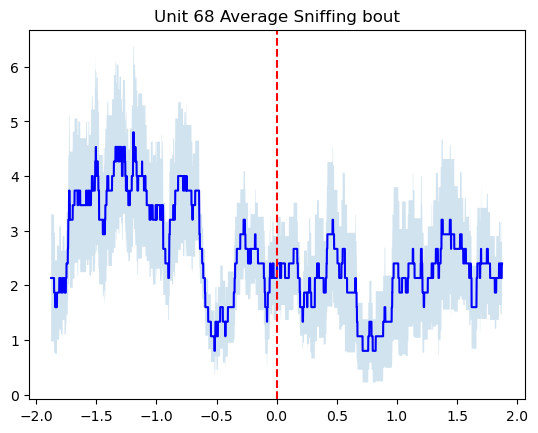

In [168]:
mean_arr = np.mean(unit_sniffing_rates_prewindow[68], axis = 0)
sem_arr = sem(unit_sniffing_rates_prewindow[68], axis=0)
pos_sem = mean_arr+sem_arr
neg_sem = mean_arr-sem_arr
sem_arr = sem(sniff_arr, axis=0)
x = np.array  (range  (    -int(mean_arr.shape[0]/2),int(mean_arr.shape[0]/2)   )    )
plt.plot(x*.001, mean_arr, c= 'b')
plt.axvline(x=0, color='r', linestyle='--')
plt.fill_between(x*.001, neg_sem, pos_sem, alpha=0.2)
plt.title('Unit 68 Average Sniffing bout')
plt.show()

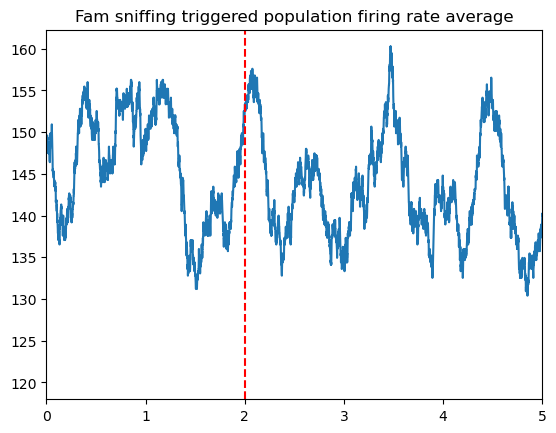

In [14]:
mean_arr = np.mean(fam_event_firingrates, axis=0)
sem_arr = sem(fam_event_firingrates, axis=0)
x = np.array(range(len(mean_arr)))
plt.plot(.001*x, mean_arr)
plt.axvline(x=2, color='r', linestyle='--')
plt.xlim(0,5)
plt.title('Fam sniffing triggered population firing rate average')
#plt.fill_between(range(len(mean_arr)), mean_arr-sem_arr, mean_arr+sem_arr, alpha=0.2)
plt.show()

In [88]:
cagemate_path ='.\\proc_old_backup\\20221219_141311_6_1_cagemate_merged.rec\\phy'
    
cagemate_timestamps, cagemate_clusters_array = get_spike_specs(cagemate_path)
cagemate_spiketrain = get_spiketrain(cagemate_timestamps, 20)

cagemate_sniffing_bouts = boris.get_behavior_bouts(cagemate_df, 'subject', ['anogential sniffing', 'face sniffing'], 2, .3)
cagemateevent_firingrates = get_event_firing_rates(cagemate_sniffing_bouts, cagemate_timestamps, 2, 1, 20, 20000)


-0.69635 you are losing this many seconds of recording data
-0.69635 you are losing this many seconds of recording data


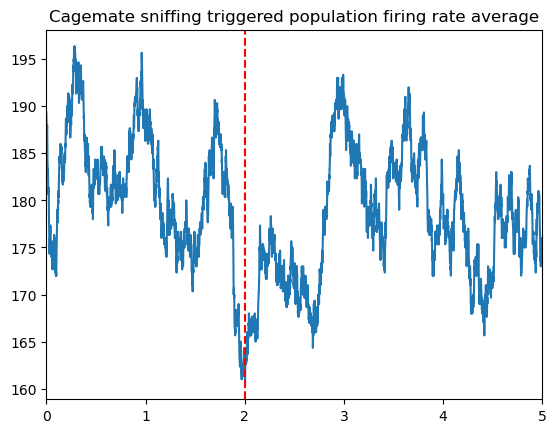

In [98]:
mean_arr = np.mean(cagemateevent_firingrates, axis=0)
sem_arr = sem(cagemateevent_firingrates, axis=0)
x = np.array(range(len(mean_arr)))
plt.plot(.001*x, mean_arr)
plt.axvline(x=2, color='r', linestyle='--')
plt.xlim(0,5)
plt.title('Cagemate sniffing triggered population firing rate average')
#plt.fill_between(range(len(mean_arr)), mean_arr-sem_arr, mean_arr+sem_arr, alpha=0.2)
plt.show()

-0.55855 you are losing this many seconds of recording data
-0.55855 you are losing this many seconds of recording data


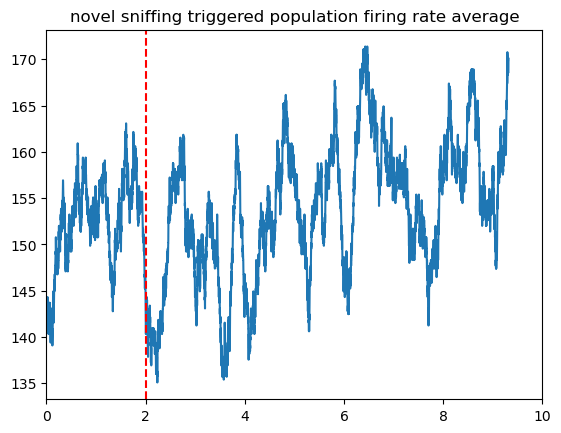

In [102]:
novel_path ='.\\proc_old_backup\\20221219_124942_6_1_novel_merged.rec\\phy'
    
novel_timestamps, novel_clusters_array = get_spike_specs(novel_path)
novel_spiketrain = get_spiketrain(novel_timestamps, 20)

novel_sniffing_bouts = boris.get_behavior_bouts(novel_df, 'subject', ['anogential sniffing', 'face sniffing'], 2, .3)
novelevent_firingrates = get_event_firing_rates(novel_sniffing_bouts, novel_timestamps, 2, 1, 20, 20000)    

mean_arr = np.mean(novelevent_firingrates, axis=0)
sem_arr = sem(novelevent_firingrates, axis=0)
x = np.array(range(len(mean_arr)))
plt.plot(.001*x, mean_arr)
plt.axvline(x=2, color='r', linestyle='--')
plt.xlim(0,10)
plt.title('novel sniffing triggered population firing rate average')
#plt.fill_between(range(len(mean_arr)), mean_arr-sem_arr, mean_arr+sem_arr, alpha=0.2)
plt.show()

In [12]:
x = np.array(range(len(fam_all_sniff)))
plt.figure(figsize = (25,5))
plt.ylim(0,35)
plt.plot(x, fam_all_sniff, c = 'r', linewidth = 2)
plt.plot(x, fam_baseline_snippet, c = 'k', linewidth = .5)
plt.title('FAM', fontsize = 40)

x = np.array(range(len(novel_all_sniff)))
plt.figure(figsize = (25,5))
plt.plot(x, novel_all_sniff, c = 'r', linewidth = 2)
plt.plot(x, novel_baseline_snippet, c = 'k', linewidth = .5)
plt.title('Novel', fontsize = 40)

x = np.array(range(len(cagemate_all_sniff)))
plt.figure(figsize = (25,5))
plt.plot(x, cagemate_all_sniff, c = 'r', linewidth = 2)
plt.plot(x, cagemate_baseline_snippet, c = 'k', linewidth = .5)
plt.title('Cagemate', fontsize = 40)

NameError: name 'fam_all_sniff' is not defined

In [13]:
# Create the raster plot
plt.figure(figsize = (12,1))
plt.eventplot(spiketrain_array)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')
plt.title('Raster Plot')
plt.show()

NameError: name 'spiketrain_array' is not defined

<Figure size 1200x100 with 0 Axes>

In [14]:
fake_array = np.array([[1,4], [2,3]])
new_array = np.sort(fake_array.flatten())
print(fake_array)
print(new_array)

[[1 4]
 [2 3]]
[1 2 3 4]


In [15]:
reshaped_array = np.reshape(new_array*1000, (2,2))

In [16]:
reshaped_array

array([[1000, 2000],
       [3000, 4000]])

In [17]:
fake_data = [1,2,3,4,5]
fake_data.extend([1,2])
fake_data

[1, 2, 3, 4, 5, 1, 2]

In [18]:
nested_dict = {'a' : {'b' : [[2,3], [3,3]]}}
nested_dict['a']['b']

[[2, 3], [3, 3]]

In [19]:
empty_list = []
snif_bouts = [[1,2], [8,10]]
anogential_bouts = [[4,9]]
empty_list.append(snif_bouts)
empty_list.append(anogential_bouts)
bouts = np.concatenate(empty_list)

In [20]:
organizer = np.argsort(bouts[:,0])

In [21]:
bouts = bouts[organizer]

In [22]:
bouts

array([[ 1,  2],
       [ 4,  9],
       [ 8, 10]])

In [23]:
subject = ['mouse', 'mouse1']
'_'.join(subject)
    

'mouse_mouse1'

In [24]:
if type(subject) == list:
    print('yes')
else:
    print('no')

yes


In [25]:
subject = ['subject', 'cage mate']
behavior = ['face sniffing', 'anogenital sniffing']
if type(subject) == list:
    subject = '_'.join(subject)
if type(behavior) == list:
    behavior = '_'.join(behavior)
subject = subject.replace(" ", "")
behavior = behavior.replace(" ","")
filename = f"{subject}_{behavior}_bouts.npy"
print(filename)

subject_cagemate_facesniffing_anogenitalsniffing_bouts.npy


In [26]:
fake_array = np.array([1,2,3,4,5,6,7])
i = 3

fake_array = fake_array[i:]
fake_array

array([4, 5, 6, 7])

In [27]:
subject = 'mouse'
if type(subject) != list:
    subject = [subject]


In [28]:
print(subject)

['mouse']


In [29]:
arrays = []
one_nparray = np.array([[1,2],[1,3]])
#two_nparray = np.array([[1,2],[1,3]])
arrays.append(one_nparray)
#arrays.append(two_nparray)

In [30]:
len(arrays)

1

In [31]:
long_nparray = np.concatenate(arrays)
long_nparray

array([[1, 2],
       [1, 3]])

In [32]:
spiketrain = np.array([0,2,3,1,2,3,4,5,0,0,0,0,1,2,3,4,5,3,4,5,1,1,1,1,1,0,0,0,0,0,0,0])
smoothing_window = 3
timebin = 2

len(spiketrain)


32

In [33]:
if timebin != 1:
    current_timebin = 0
    temp_spiketrain = np.zeros(math.ceil(len(spiketrain)/timebin))
    for i in range(0, len(spiketrain), timebin):
        try:
            temp_spiketrain[current_timebin] = sum(spiketrain[i:i+timebin])
            current_timebin += 1
        except IndexError:
            #should i pad here or just drop it? 
            temp_spiketrain[current_timebin] = sum(spiketrain[i:])
    spiketrain = temp_spiketrain

spiketrain


array([2., 4., 5., 9., 0., 0., 3., 7., 8., 9., 2., 2., 1., 0., 0., 0.])

In [34]:
len(spiketrain)

16

In [35]:
firing_rate = np.empty(len(spiketrain) - smoothing_window)
rolling_sum = sum(spiketrain[0:smoothing_window])
for i in range(len(firing_rate)):
    firing_rate[i] = rolling_sum / (smoothing_window * .001 * timebin)
    rolling_sum = rolling_sum - spiketrain[i] + spiketrain[i+smoothing_window]
firing_rate

array([1833.33333333, 3000.        , 2333.33333333, 1500.        ,
        500.        , 1666.66666667, 3000.        , 4000.        ,
       3166.66666667, 2166.66666667,  833.33333333,  500.        ,
        166.66666667])

In [36]:
labels_dict = {'1': 'good', '2': 'mua', '3':'good'}
spike_dict = {'1': np.array([2,4,5]), '2': np.array([1,3]), '3': np.array([0,6,7])}
recording_length = 10
unit_spiketrains = {}
for unit in spike_dict.keys():
    if labels_dict[unit] == 'good':
        unit_spiketrains[unit] = get_spiketrain(spike_dict[unit], recording_length, 1000)



0 [2 4 5]
1 [2 4 5]
2 [2 4 5]
0 [0 6 7]
1 [0 6 7]
2 [0 6 7]


In [37]:
unit_spiketrains

{'1': array([0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.]),
 '3': array([1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])}

In [43]:
unit_firing_rates = {}
unit_spiketrains = get_unit_spiketrains(labels_dict, spike_dict, 10, 1000)
for unit in unit_spiketrains.keys():
    unit_firing_rates[unit] = get_firing_rate(spike_dict[unit], 10, 2, 2, 1000)

0 [2 4 5]
1 [2 4 5]
2 [2 4 5]
0 [0 6 7]
1 [0 6 7]
2 [0 6 7]
0 [2 4 5]
1 [2 4 5]
2 [2 4 5]
0 [0 6 7]
1 [0 6 7]
2 [0 6 7]


In [44]:
unit_firing_rates

{'1': array([250., 750., 500.,   0.]), '3': array([250.,   0., 500., 500.])}